In [1]:

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import json
from copy import deepcopy
from tqdm import tqdm
from pathlib import Path
from cplAE_TE.utils.tree_helpers import HTree

from cplAE_TE.utils.load_helpers import get_paths, load_dataset, load_summary_files

sns.set()
sns.set_style('ticks',{'axes.grid' : False})
%matplotlib inline

In [2]:
O = load_dataset(min_sample_thr=10)
path = get_paths()

CVdict = load_summary_files(data_type='NM',
                                alpha_T=1.0,
                                alpha_E=1.0,
                                lambda_TE=1.0,
                                latent_dim=3,
                                aug=1,
                                fold_list=np.arange(44),
                                key_list=['XrT','XrT_from_XE','XrE','XrE_from_XT','train_ind','val_ind','test_ind'])

Loading aT_1-0_aE_1-0_cs_1-0_ad_1


In [3]:
# This cell loads DE genes for each node and all child nodes (recursively till leaf nodes). 
# Not used for results in the manuscript, but could be useful for analyzing different marker gene sets.

# Internal node legend:
# n109 : Pvalb
#  n90 : Sst
#  n63 : Vip
#  n76 : Lamp5+Sncg

htree = HTree(htree_file = path['htree'])
G = sio.loadmat(path['proc_DE_gene_dict'], squeeze_me=True)

avail_nodes = list(G.keys())
for class_lbl in ['n109','n90','n63','n76']:
    subtree_nodes = htree.get_descendants(node=class_lbl,leafonly=False)
    subtree_nodes = list(set(subtree_nodes) & set(avail_nodes))
    DEgenes = []
    for node in subtree_nodes:
        DEgenes.extend(G[node])
    DEgenes = [gene.rstrip().lstrip() for gene in DEgenes]
    DEgenes = list(set(DEgenes) & set(O['gene_id'].tolist()))
    print(f'{len(DEgenes)} diff. exp. genes found for descendants of {class_lbl}')

96 diff. exp. genes found for descendants of n109
113 diff. exp. genes found for descendants of n90
110 diff. exp. genes found for descendants of n63
106 diff. exp. genes found for descendants of n76


In [4]:
gene_subsets = {}

#Marker genes from the Tasic 2018 paper: 
gene_subsets['markers_sst_pvalb'] = ['Sst', 'Chodl', 'Nos1', 'Mme', 'Tac1', 
                                     'Tacr3', 'Calb2', 'Nr2f2', 'Myh8', 'Tac2', 
                                     'Hpse', 'Crhr2', 'Crh', 'Esm1', 'Rxfp1', 
                                     'Nts', 'Pvalb', 'Gabrg1', 'Th', 'Calb1', 
                                     'Akr1c18', 'Sema3e', 'Gpr149', 'Reln', 
                                     'Tpbg', 'Cpne5', 'Vipr2', 'Nkx2-1']

gene_subsets['markers_lamp5_serpinf1_sncg_vip'] = ['Lamp5', 'Ndnf', 'Krt73', 'Fam19a1', 
                                                   'Pax6', 'Ntn1', 'Plch2', 'Lsp1', 'Lhx6', 
                                                   'Nkx2.1', 'Vip', 'Sncg', 'Slc17a8', 'Nptx2', 
                                                   'Gpr50', 'Itih5', 'Serpinf1', 'Igfbp6', 
                                                   'Gpc3', 'Lmo1', 'Ptprt', 'Rspo4', 'Chat', 
                                                   'Crispld2', 'Col15a1', 'Pde1a']

#Neuropeptide genes in the Smith 2019 paper: 
gene_subsets['npp']  = ['Vip','Npy','Sst','Penk','Tac2','Cck','Crh',
                             'Tac1','Pdyn','Cort','Pthlh','Pnoc','Adcyap1',
                             'Trh','Grp','Nmb','Nts','Rln1','Vipr1','Vipr2',
                             'Npy1r','Npy2r','Npy5r','Sstr1','Sstr2',
                             'Sstr3','Sstr4','Oprd1','Oprm1','Tacr3',
                             'Cckbr','Crhr1','Crhr2','Tacr1','Oprk1',
                             'Pth1r','Oprl1','Adcyap1r1','Trhr','Trhr2',
                             'Grpr','Nmbr','Ntsr1','Ntsr2','Rxfp1','Rxfp2',
                             'Rxfp3']

gene_subsets['combined_markers'] = gene_subsets['markers_lamp5_serpinf1_sncg_vip']+gene_subsets['markers_sst_pvalb']

In [5]:
# markers and npp have some genes in common
print(set(gene_subsets['combined_markers']) & set(gene_subsets['npp']))

{'Crh', 'Tacr3', 'Crhr2', 'Rxfp1', 'Tac1', 'Tac2', 'Nts', 'Sst', 'Vipr2', 'Vip'}


In [6]:
subset = 'npp'

gene_list = gene_subsets[subset]
# find location of all genes
gene_inds = []
for gene in gene_list:
    ind = np.flatnonzero(np.isin(O['gene_id'],gene))
    if ind.size==1:
        gene_inds.append(ind[0])
gene_inds = np.array(gene_inds)
genes_found = O['gene_id'][gene_inds].tolist()

In [7]:
#Some genes are not present in the list of 1252 genes used as autoencoder input
not_found=list(set(gene_list)-set(genes_found))
print(f'{len(not_found)} out of {len(gene_list)} genes not found in dataset')

11 out of 47 genes not found in dataset


In [8]:
cv_list = CVdict.keys()
XrT = np.concatenate([CVdict[cv]['XrT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrT_from_XE = np.concatenate([CVdict[cv]['XrT_from_XE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE = np.concatenate([CVdict[cv]['XrE'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
XrE_from_XT = np.concatenate([CVdict[cv]['XrE_from_XT'][CVdict[cv]['val_ind']] for cv in cv_list],axis=0)
val_ind = np.concatenate([CVdict[cv]['val_ind'] for cv in cv_list],axis=0)

### T reconstruction $R^2$

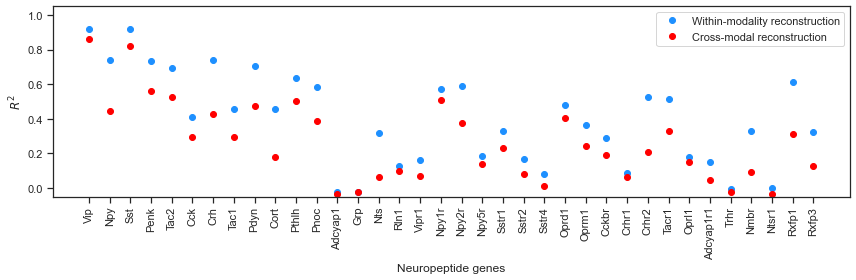

In [9]:
R2_T_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)
R2_E_to_T = 1 - np.mean((O['T_dat'][val_ind,:] - XrT_from_XE)**2,axis=0)/np.var(O['T_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(12,4))
plt.plot(np.arange(len(genes_found)), R2_T_to_T[gene_inds],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(len(genes_found)), R2_E_to_T[gene_inds],'o',color='red',label='Cross-modal reconstruction')
plt.legend(frameon=True)
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_xlabel('Neuropeptide genes')
ax.set_ylim(-0.05,1.05)
ax.set_xticks(np.arange(len(genes_found)))
ax.set_xticklabels(genes_found,rotation=90)
plt.tight_layout()
#plt.savefig(figure_path+f'R2_{subset}_genes.png',dpi=300)
#plt.savefig(figure_path+f'Fig_ED_6.jpg',dpi=300)
#df = pd.DataFrame({'genes':genes_found,'within':R2_T_to_T[gene_inds],'cross':R2_E_to_T[gene_inds]})
#df.to_csv(figure_path+f'Source_data_Fig_ED_6.csv',index=False)

### E reconstruction $R^2$

In [10]:
# set entries that were not measured to nan (these are in a small number - 273 among the 3411 x 68 entries)
O['E_dat'] = deepcopy(O['XE'])
O['E_dat'][~O['maskE'].astype(bool)]=np.nan

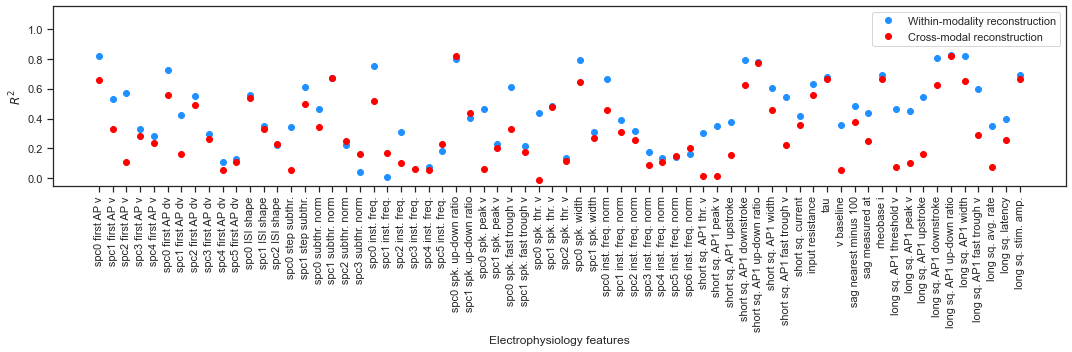

In [11]:
R2_E_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)
R2_T_to_E = 1 - np.nanmean((O['E_dat'][val_ind,:] - XrE_from_XT)**2,axis=0)/np.nanvar(O['E_dat'][val_ind,:],axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(O['pcipfx_names'].size), R2_E_to_E[:],'o',color='dodgerblue',label='Within-modality reconstruction')
plt.plot(np.arange(O['pcipfx_names'].size), R2_T_to_E[:],'o',color='red',label='Cross-modal reconstruction')
plt.legend(frameon=True)
ax = plt.gca()
ax.set_ylabel(r'$R^2$')
ax.set_ylim(-0.05,1.15)
ax.set_xlabel("Electrophysiology features")
ax.set_xticks(np.arange(O['pcipfx_names'].size))
ax.set_xticklabels(O['pcipfx_names'],rotation=90)
plt.tight_layout()
plt.show()
#plt.savefig(path['package'] / 'assets/Fig_ED_7.jpg',dpi=300)
#df = pd.DataFrame({'features':O['pcipfx_names'],'within':R2_E_to_E[:],'cross':R2_T_to_E[:]})
#df.to_csv(figure_path+f'Source_data_Fig_ED_7.csv',index=False)

In [12]:
t_types = deepcopy(O['well_sampled_sorted_t_types'])
t_type_labels = deepcopy(O['cluster'])

### T reconstruction matrix

In [13]:
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.mean(O['T_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.mean(XrT_from_XE[this_type,:],axis=0))
    
true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)

Pearson r per type mean: 0.89 sd: 0.10
Pearson r per feature mean: 0.83 sd: 0.15


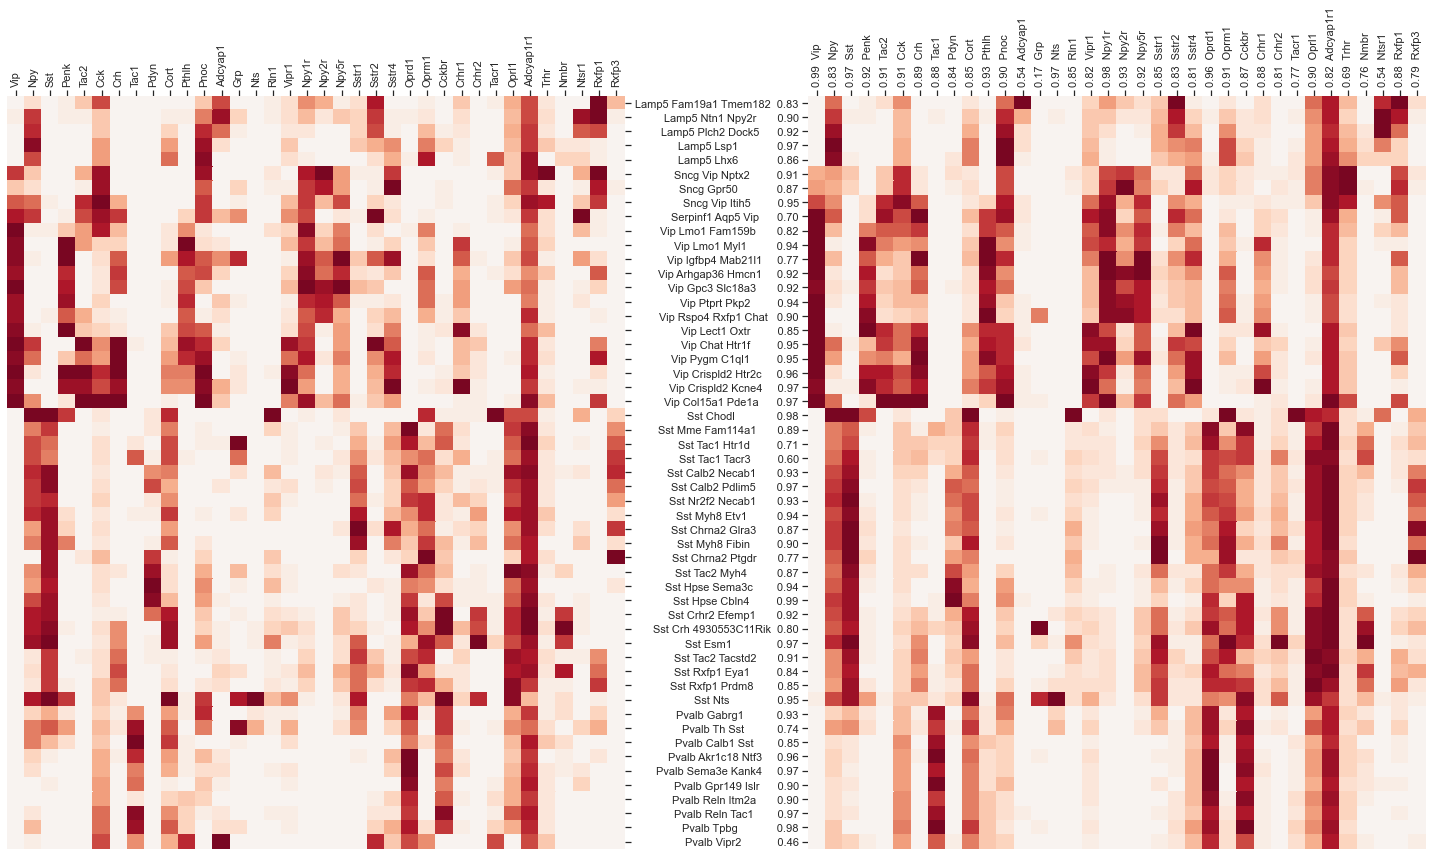

In [14]:
M_true = true_vals[:,gene_inds]/np.max(true_vals[:,gene_inds],axis=0)
M_pred = pred_vals[:,gene_inds]/np.max(pred_vals[:,gene_inds],axis=0)

Pearson_R_per_type_E_to_T = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_E_to_T.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_E_to_T):0.2f} sd: {np.std(Pearson_R_per_type_E_to_T):0.2f}')

Pearson_R_per_feature = []
for i in range(M_true.shape[1]):
    C_ij = np.corrcoef(M_true[:,i],M_pred[:,i])
    Pearson_R_per_feature.append(C_ij[0,1])
print(f'Pearson r per feature mean: {np.mean(Pearson_R_per_feature):0.2f} sd: {np.std(Pearson_R_per_feature):0.2f}')

xlabels = genes_found

xname = [f.rstrip().lstrip() for f in xlabels]
xdata = Pearson_R_per_feature
xlabels2 = [f'{a:0.2f}  '+f'{b}' for (a,b) in zip(xdata,xname)] 

yname = [t for t in t_types]
ydata = [f'{x:.2f}' for x in Pearson_R_per_type_E_to_T]
ylabels = [f'{a:<23s}'+f'{b:>4s}' for (a,b) in zip(yname,ydata)]


plt.figure(figsize = (20,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)


ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,center=0,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)
ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels2,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

#plt.savefig(path['package'] / 'assets/Fig_2a-b.pdf')

### E reconstruction matrix

In [15]:
true_vals = []
pred_vals = []

for t in t_types:
    this_type = t_type_labels[val_ind]==t
    true_vals.append(np.nanmean(O['E_dat'][val_ind[this_type],:],axis=0))
    pred_vals.append(np.nanmean(XrE_from_XT[this_type,:],axis=0))

true_vals = np.concatenate(np.expand_dims(true_vals,0),axis=0)       
pred_vals = np.concatenate(np.expand_dims(pred_vals,0),axis=0)    

In [16]:
#Threshold chosen to match number of genes in the previous plot
keep_feature_ind = R2_E_to_E > 0.42
M_true = true_vals[:,keep_feature_ind]/np.max(np.abs(true_vals[:,keep_feature_ind]),axis=0)
M_pred = pred_vals[:,keep_feature_ind]/np.max(np.abs(pred_vals[:,keep_feature_ind]),axis=0)

Pearson r per type mean: 0.98 sd: 0.02
Pearson r per feature mean: 0.95 sd: 0.04


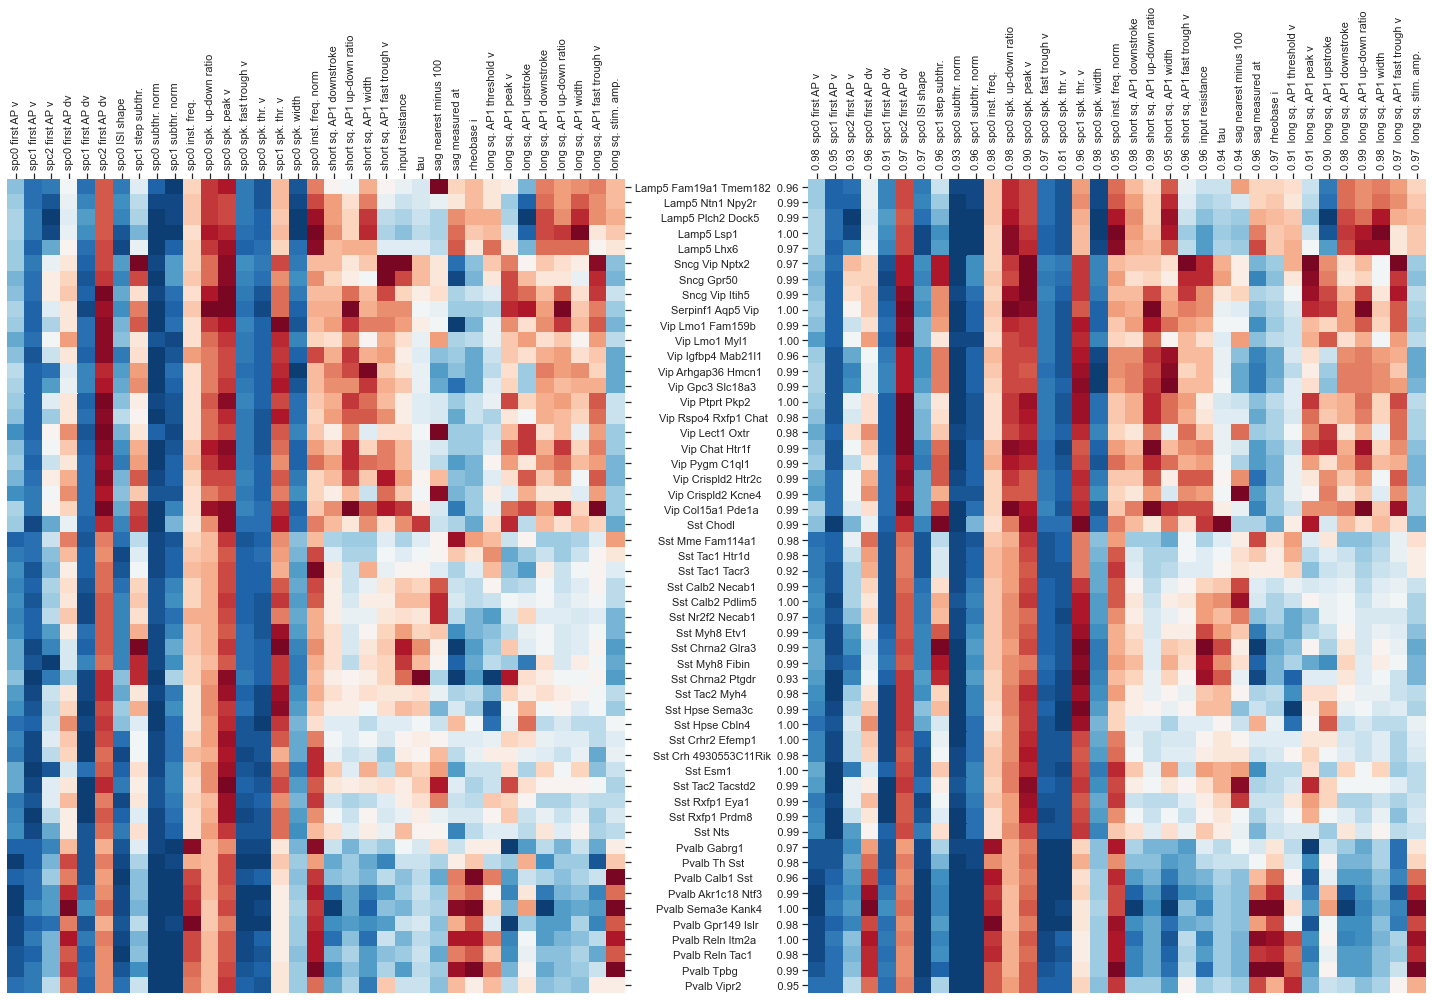

In [17]:
Pearson_R_per_type_T_to_E = []
for i in range(M_true.shape[0]):
    C_ij = np.corrcoef(M_true[i,:],M_pred[i,:])
    Pearson_R_per_type_T_to_E.append(C_ij[0,1])
print(f'Pearson r per type mean: {np.mean(Pearson_R_per_type_T_to_E):0.2f} sd: {np.std(Pearson_R_per_type_T_to_E):0.2f}')

Pearson_R_per_feature = []
for i in range(M_true.shape[1]):
    C_ij = np.corrcoef(M_true[:,i],M_pred[:,i])
    Pearson_R_per_feature.append(C_ij[0,1])
print(f'Pearson r per feature mean: {np.mean(Pearson_R_per_feature):0.2f} sd: {np.std(Pearson_R_per_feature):0.2f}')

xlabels = O['pcipfx_names'][keep_feature_ind]

xname = [f.rstrip().lstrip() for f in O['pcipfx_names'][keep_feature_ind]]
xdata = Pearson_R_per_feature
xlabels2 = [f'{a:0.2f}  '+f'{b}' for (a,b) in zip(xdata,xname)] 

yname = [t.rstrip().lstrip() for t in t_types]
ydata = [f'{x:.2f}' for x in Pearson_R_per_type_T_to_E]
ylabels = [f'{a:<23s}'+f'{b:>4s}' for (a,b) in zip(yname,ydata)]

plt.figure(figsize = (20,14))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=-1,vmax=1,cbar=False,
            cmap=sns.color_palette("RdBu_r", 40))
cbar_kws={"aspect":30,"shrink":.5,"use_gridspec":False,"location":"right"}
ax = plt.gca()
ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)

ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=-1,vmax=1,cbar=False,cbar_kws=cbar_kws,
            cmap=sns.color_palette("RdBu_r", 40),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)

ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels2,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

#plt.savefig(path['package'] / 'assets/Fig_2c-d.pdf')

### Summary for each t-type

In [18]:
#E features displayed before and after. 
ind_new = R2_E_to_E>0.42
ind_old = R2_T_to_E>0.252
print(f'{np.sum(np.logical_and(ind_new,ind_old))} selected features are the same')

27 selected features are the same
